In [24]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

In [2]:
df = pd.read_csv("train_dataset.csv").dropna(subset=["language"]).reset_index()
test = pd.read_csv("test_dataset.csv")
labels = df.iloc[:,-1]

In [3]:
zeroR = [2] * test.shape[0]
print(f"The ZeroR train accuracy is {1839/3004}")

The ZeroR train accuracy is 0.6121837549933422


In [4]:
def OneR(df, col, labels):
    levels = {}

    if df.dtypes[col]=='int64':
        bins = np.histogram(df[col], bins=4)[1]
        values = pd.DataFrame({'var' :   pd.Series(np.digitize(df[col], bins)), 
                               'label' : labels})  

    else:
        if len(df[col].unique())<100:
            values = pd.DataFrame({'var' :  df[col], 'label' : labels})
        else:
            return [] # too computationally heavy if too many categories
    
    for x in values['var'].unique():
        class_ = values[values['var'] == x].label.value_counts().nlargest(1, keep='all')

        if len(class_)==0: 
            print(class_)
        
        if len(class_)>1: levels[x] = class_.sample(n=1)
        levels[x] = class_.index[0]

    pred = []
    for i in range(values.shape[0]):
        pred.append(levels[values['var'][i]])
    return(pred)

In [5]:
def OneR_fit(train, test, col):
    levels = {}
    
    # values is df with the binned values

    if train.dtypes[col]=='int64':
        bins = np.histogram(train[col], bins=4)[1]
        values = pd.DataFrame({'var' :   pd.Series(np.digitize(train[col], bins)), 
                               'label' : train['imdb_score_binned']})  

    else:
        if len(train[col].unique())<100:
            values = pd.DataFrame({'var' :  train[col], 'label' : train['imdb_score_binned']})
        else:
            return [] # too computationally heavy if too many categories
    
    for x in values['var'].unique():
        class_ = values[values['var'] == x].label.value_counts().nlargest(1, keep='all')
        
        if len(class_)>1: levels[x] = class_.sample(n=1)
        levels[x] = class_.index[0]

    # bin the test values
    test_values = pd.Series(np.digitize(test[col], bins))

    # Make predictions
    pred = []
    for i in range(len(test_values)):
        pred.append(levels[test_values[i]])
    return(pred)  

In [6]:
pred_list = {}
for i in range(1,df.shape[1]-1):
    col = df.columns[i]
    predictions = OneR(df, col, labels)
    pred_list[col] = predictions

In [7]:
scores = {}
for col in pred_list.keys():
    if len(pred_list[col])>0:
        accuracy = pd.DataFrame({'pred':pred_list[col], 'actual':labels})
        accuracy['correct'] = accuracy.actual==accuracy.pred
        score = sum(accuracy.correct)/len(accuracy.correct)
        scores[col] = score
top_score = max(scores, key=scores.get)

In [8]:
print(f"The OneR is {top_score} with train accuracy : {scores[top_score]}")

The OneR is num_voted_users with train accuracy : 0.6363636363636364


OneR output

In [9]:
test_labs = OneR_fit(df, test, top_score)
kaggle = pd.DataFrame({'id':test['id'], 'imdb_score_binned': test_labs})
kaggle.to_csv("results_OneR.csv", index=False)

ZeroR output

In [10]:
kaggle0 = pd.DataFrame({'id':test['id'], 'imdb_score_binned': [2] * test.shape[0]})
kaggle0.to_csv("results_ZeroR.csv", index=False)

# Random Forest time baby
### *cracks knuckles*

## Pre Processing

In [11]:
def preproc(df):
    # Fix the genre column

    genres = df['genres'].str.split("|")
    genres = list(set([a for b in genres.tolist() for a in b])) # get all the unique genres

    for x in genres:
        df[x] = df.genres.str.count(x) # this is gonna give 0 or 1 for each row and genre

    df.drop(["genres"], axis=1, inplace=True)

    # One hot encode language, country, content_rating
    df = pd.get_dummies(df, columns=["language", "country", "content_rating"], dtype=float)

    ids = df.id
    df = df.iloc[:,2:].select_dtypes(['number'])

    return([df, ids])

In [12]:
df = df.iloc[:, :-1]
Data, ids_train = preproc(df)
Test, ids_test = preproc(test)

In [13]:
# ensure the one hot encoded columns are all the same and in the same order

train_cols = Data.columns
test_cols = Test.columns
missing_levels = train_cols.difference(test_cols)

for x in missing_levels:
    Test[x] = 0
Test = Test[Data.columns]

In [14]:
Data_copy = Data.copy() # Make a copy to recall the column names after scaling.

Data_scaler = preprocessing.MinMaxScaler() # create scaler
Data_scaler.fit(Data) #fit scaler
Data = Data_scaler.fit_transform(Data)
Data_df = pd.DataFrame(Data, columns = Data_copy.columns)

Test = Data_scaler.fit_transform(Test)
Test_df = pd.DataFrame(Test, columns = Data_copy.columns)

In [15]:
# setup matplotlib 
%matplotlib inline 
%config InlineBackend.figure_format = 'retina'
#plt.style.use("ggplot")

In [16]:
num_features = 20 # pick a number of feature importances and reasses later

model_rfi = RandomForestClassifier(n_estimators=100) #random forest for finding the important features
model_rfi.fit(Data, labels)
fs_indices_rfi = np.argsort(model_rfi.feature_importances_)[::-1][0:num_features]

In [17]:
best_features_rfi = Data_df.columns[fs_indices_rfi].values
best_features_rfi

array(['num_voted_users', 'num_user_for_reviews', 'duration',
       'num_critic_for_reviews', 'title_year', 'gross',
       'actor_3_facebook_likes', 'director_facebook_likes',
       'movie_facebook_likes', 'cast_total_facebook_likes',
       'actor_2_facebook_likes', 'average_degree_centrality',
       'actor_1_facebook_likes', 'facenumber_in_poster', 'Drama',
       'Action', 'content_rating_PG-13', 'Thriller', 'content_rating_R',
       'country_USA'], dtype=object)

In [18]:
feature_importances_rfi = model_rfi.feature_importances_[fs_indices_rfi]
feature_importances_rfi

array([0.11224323, 0.07279787, 0.06044942, 0.05816308, 0.05758889,
       0.05566242, 0.05182709, 0.04882495, 0.04851514, 0.04793636,
       0.04656806, 0.04243409, 0.04127253, 0.02424229, 0.02370499,
       0.01329259, 0.01182959, 0.01063837, 0.01056648, 0.01006152])

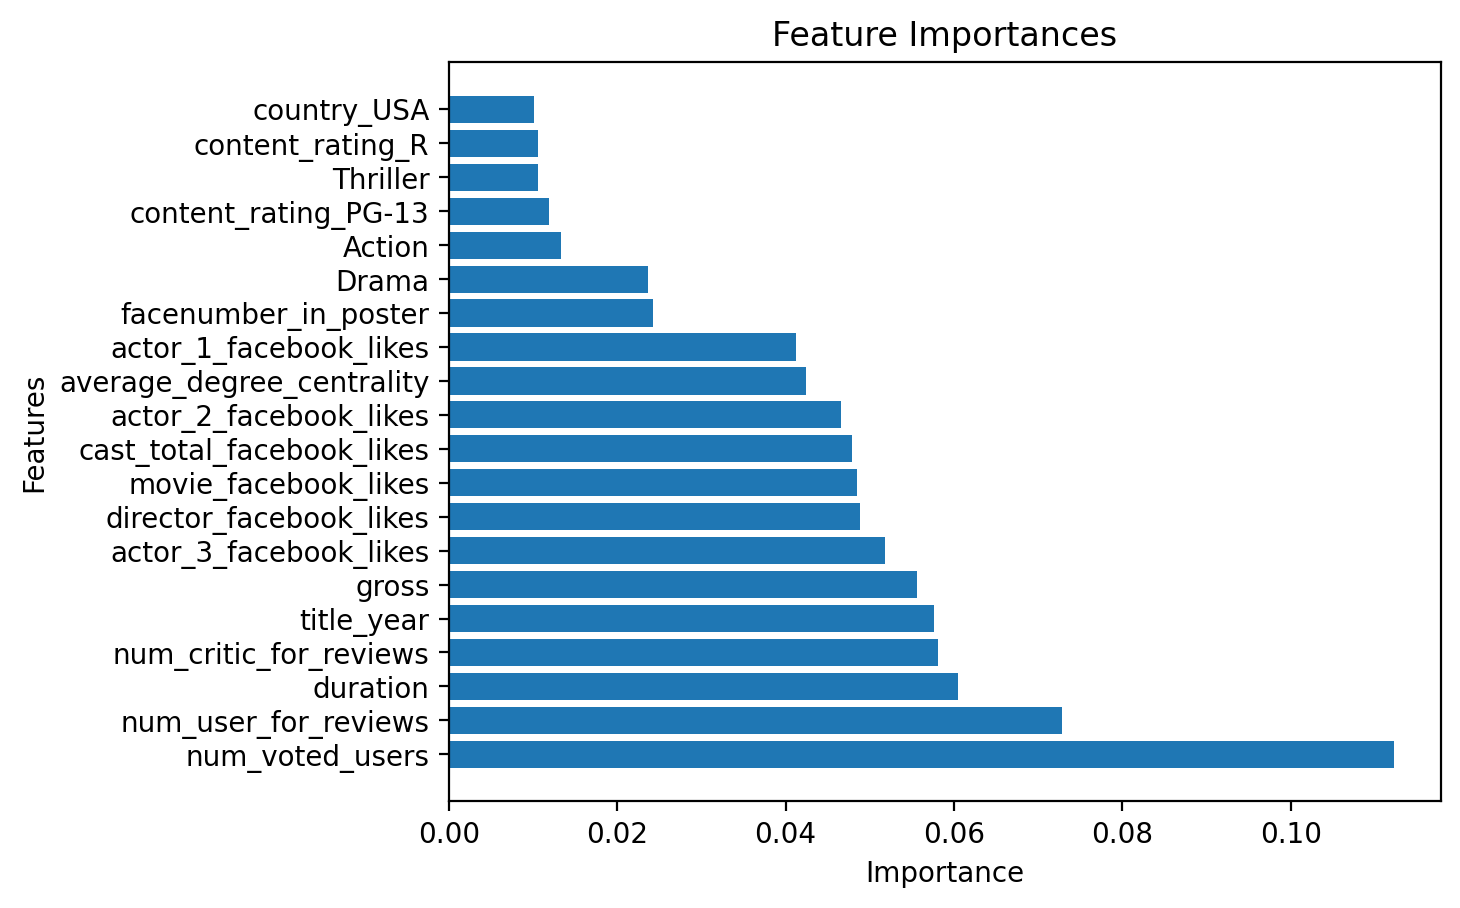

In [19]:
plt.barh(best_features_rfi, feature_importances_rfi)
plt.title('Feature Importances')
plt.xlabel("Importance")
plt.ylabel("Features")
plt.show()

# below is how much of the variance each of the best 20 features can explain

In [21]:
D_train_fs = Data[:, fs_indices_rfi[0:15]]
D_test_fs  = Test[:, fs_indices_rfi[0:15]]

In [23]:
perf_metric = "accuracy" 
criterion = ["gini", "entropy"]

cv_method = RepeatedStratifiedKFold(n_splits=5,
                                    n_repeats=3,
                                    random_state=999)

In [25]:
# hyper parameters to search through

depth = np.linspace(1, 20, 20, endpoint=True).astype(int) # maximum depth of a tree
n_estimators = [100, 250, 500] # number of trees
params_RF = dict(criterion=criterion, max_depth=depth, n_estimators=n_estimators)

gs_RF = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                           param_distributions=params_RF, 
                           cv=cv_method,
                           verbose=0,
                           n_iter=35,
                           scoring=perf_metric)

gs_RF.fit(D_train_fs, labels);

In [26]:
print(f"Best parameters: {gs_RF.best_params_}")
print(f"Best score: {gs_RF.best_score_}")

Best parameters: {'n_estimators': 500, 'max_depth': 17, 'criterion': 'gini'}
Best score: 0.7373736365317062


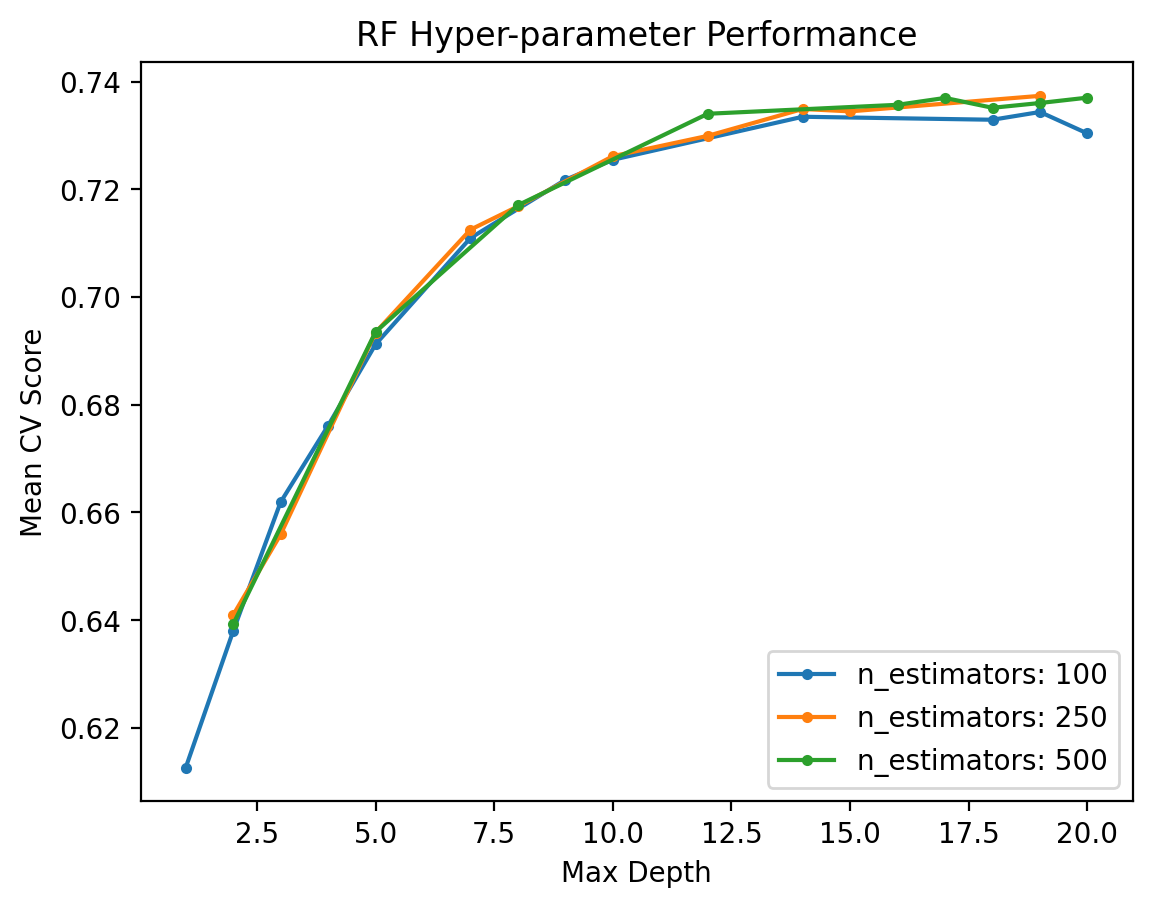

In [27]:
results_RF = pd.DataFrame(gs_RF.cv_results_['params'])
results_RF['test_score'] = gs_RF.cv_results_['mean_test_score']

for i in results_RF['n_estimators'].unique():
    perf = results_RF[results_RF['n_estimators'] == i]
    perf_average = perf.groupby('max_depth').agg({'test_score': 'mean'})
    plt.plot(perf_average, marker = '.', label = 'n_estimators: ' + str(i))
    
plt.legend()
plt.xlabel('Max Depth')
plt.ylabel("Mean CV Score")
plt.title("RF Hyper-parameter Performance")
plt.show()

# like before the graph indicates we don't need to search through higher parameters.
# the number of estimators didn't make a huge difference, the 500 and 250 curves are quite similar, 100 estimators 
# has a big jump then behaves like the other curves.

In [30]:
test_pred = gs_RF.predict(D_test_fs)

In [32]:
RF_kaggle = pd.DataFrame({'id':ids_test, 'imdb_score_binned': test_pred})
RF_kaggle.to_csv("results_RF.csv", index=False)

# Useful Code (Preprocessing)

### Genres - Fixed

In [ ]:
genres = df['genres'].str.split("|")
genres = list(set([a for b in genres.tolist() for a in b])) # get all the unique genres

for x in genres:
    df[x] = df.genres.str.count(x) # this is gonna give 0 or 1 for each row and genre

df.drop(["genres"], axis=1, inplace=True)    


In [15]:
df.describe(include=[object])

,director_name,actor_2_name,actor_1_name,movie_title,actor_3_name,plot_keywords,language,country,content_rating,title_embedding
count,3003,3003,3003,3003,3003,3003,3003,3003,3003,3003
unique,1459,1902,1264,2941,2197,2942,32,42,12,2941
top,Steven Spielberg,Morgan Freeman,Johnny Depp,King Kong,Steve Coogan,animal name in title|ape abducts a woman|goril...,English,USA,R,[-2.8369315e-03 1.3950688e-03 -3.8431014e-04 ...
freq,21,15,30,3,7,3,2872,2381,1362,3
